# AML Fall 2021 - Task 1
In this task we are asked to estimate the brain age using a set of features extracted from the 3D brain MRI. The provided dataset has 832 features. There are 1212 samples in the training set and 776 samples in the test set.
After reading the data into the panda dataframes, we first remove the extra id columns and convert the dataframes into numpy arrays. We then proceed as follows:
1. We first __remove the features with very low normalized variance__. We define the normalized standard deviation of each feature (each column of the dataset) as $ norm_std = \sigma / (|\mu| + 1) $, where $ \sigma $ and $ \mu $ are the standard deviation and the mean of that feature, respectively. We remove features whose normalized std is less than 0.001.
2. __Scaling:__ We next subtract the mean of the features and normalize them so that all features have standard deviation of 1.
3. __Imputation:__ We then impute the missing values median of each value.
4. __Outlier detection:__ We use isolation forest outlier detector from sklearn. After fitting the model to the data, we plot the decision function of the outlier detector, which provides an anomality score for each feature (lower score means more likely to be outlier). We remove samples whose anomality score is below the threshold = 0.
5. __Feature selection:__ we used the feature_importances_ attribute of the ExtraTreesRegressor from sklearn to select features with the highest importance. Again we set a threshold (0.001) as a hyperparameter and only selected features whose feature_importances_ was above this threshold. 139 features out of 773 features were selected.
6. __Second round of imputation and outlier detection:__ After selecting the features, we return to the non-imputed data with features selected and outliers removed and impute the missing values this time using MICE imputer from sklearn. We found that it gives better results than KNN. However, now that we have reduced the data set size by keeping less features, it is much easier to MICE than in the beginning. Finally, we repeat the outlier detection procedure, by this time with a different threshold of 0.02.
7. Next, we apply four different regression models to the preprocessed data. We train ExtraTreesRegressor, HistGradientBoostingRegressor, SVM regressor and MLP on the data. It turns out that SVM and MLP give the best results with 139 features, while the random forest based methods (ExtraTreesRegressor and HistGradientBoostingRegressor) work best with lower number of features. After tuning the parameters of the models, we average the results of the MLP and SVM regressors on the test set and report it as our prediction. While tuning the parameters of the models, we tried to avoid overfitting. For example in the MLP, we used only one hidden layer and tried to minimize the number of nodes in order to keep the model simple. Also, we always evaluated the results of each regressor using K-fold cross validation on the training set, before testing them on the test set. Finally, averaging the results of two regressors, not only improves the prediction score, but also reduces the chance of overfitting.

## Results: 
The following results correspond to the results of this notebook on the test data:
Public score:  0.775519847113
Private score: 0.735522492724
We ranked 3 out of 179 groups in the private leaderboard.

In [2]:
############# load packages #############

import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.decomposition import PCA


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer

############# read training and test data from the files #############
X_train = pd.read_csv("X_train.csv").to_numpy()
X_train = X_train[:,1:]  #remove the id column
y_train = pd.read_csv("y_train.csv").to_numpy()
y_train = y_train[:,1]
X_test = pd.read_csv("X_test.csv").to_numpy()
X_test = X_test[:,1:]  #remove the id column

X_train0 = X_train
y_train0 = y_train
X_test0 = X_test

#################### preprocessing ####################

# first remove features with very low variance
normalized_std_threshold = 0.001
normalized_std = np.zeros(X_train.shape[1])
means_abs = np.zeros(X_train.shape[1])
for i in range(X_train.shape[1]):
    vec = X_train[:,i]
    means_abs[i] = np.abs(np.mean(vec[~np.isnan(vec)])) + 1
    normalized_std[i] = np.std(vec[~np.isnan(vec)])/means_abs[i]

mask = np.ones(len(normalized_std), dtype=bool)
mask[normalized_std < normalized_std_threshold] = False

X_train = X_train[:, mask]
X_test = X_test[:, mask]

# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

############ Imputation #############
# imputer = KNNImputer(n_neighbors=50) 
# X_train_sc_imp0 = imputer.fit_transform(X_train_scaled)
# X_test_sc_imp0 = imputer.fit_transform(X_test_scaled)

Imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_sc_imp0 = Imputer.fit_transform(X_train_scaled)
X_test_sc_imp0 = Imputer.fit_transform(X_test_scaled)


/home/ts/.local/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


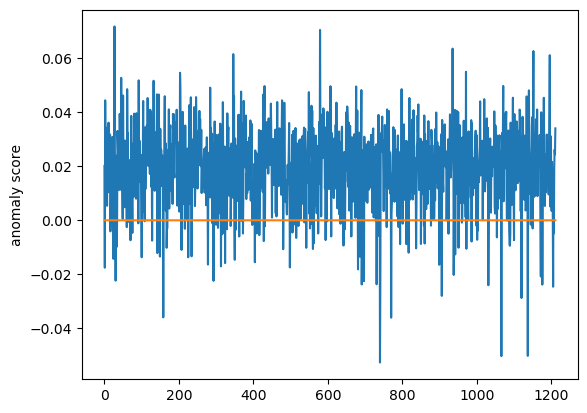

Size of training set after initial preprocessing: (1090, 773)


In [3]:
############# Outlier detection: IsolationForest #############
outlier_det = IsolationForest(random_state=0, contamination=0.1, max_features=0.5).fit(X_train_sc_imp0)
anomaly_score = outlier_det.decision_function(X_train_sc_imp0)

### to determine the contamination parameter, I propose to first plot the anomaly score function and then decide on the
### the contamination ratio based on visual thresholding.
### HERE WE NEED TO VISUALLY DETERMINE A THRESHOLD:
anomaly_threshold = 0.0
plt.plot(anomaly_score)
plt.plot(np.ones(anomaly_score.shape)*anomaly_threshold)
plt.ylabel('anomaly score')
plt.show()

outliers=np.where(anomaly_score < anomaly_threshold)

mask = np.ones(len(anomaly_score), dtype=bool)
mask[outliers[0]] = False
X_train_cl0 = X_train_sc_imp0[mask,:]
y_train_cl0 = y_train[mask]

print('Size of training set after initial preprocessing:', X_train_cl0.shape)

# Alternative Feature detection with PCA

In [4]:
pca = PCA(n_components=0.58, svd_solver='full')
x_train_pca_selected = pca.fit_transform(X_train_cl0)
print(x_train_pca_selected.shape)
# np.savetxt('variances.csv',pca.explained_variance_ratio_,delimiter=',', fmt='%1.5f') 
feature_flag = pca.components_[0,:].nonzero()[0]

(1090, 150)


In [45]:
############# Feature selection using ExtraTreesRegressor #############

selector = ExtraTreesRegressor(n_estimators=50, random_state=0, min_samples_split=0.02, max_samples=0.9, bootstrap=True)
selector = selector.fit(X_train_cl0, y_train_cl0)
selector.feature_importances_  

support = np.where(selector.feature_importances_ > 1e-3)[0]
print("support vector: ", support)
print('number of selected features:', len(support))

support vector:  [  2  15  18  23  24  26  27  29  37  39  74  84  89 103 109 111 118 127
 128 132 138 141 142 145 153 155 161 166 170 171 183 187 190 194 199 203
 214 215 216 217 222 224 226 229 238 247 258 260 267 268 282 284 285 287
 290 293 294 295 300 302 309 320 322 328 335 338 355 369 380 385 395 407
 410 415 420 426 432 435 445 450 451 457 460 470 482 489 490 491 495 498
 502 503 506 507 508 513 530 545 548 549 550 556 563 565 566 571 573 583
 584 590 591 592 599 604 610 615 617 619 620 621 624 626 632 637 648 649
 655 657 658 659 666 667 671 679 682 687 693 699 703 710 712 720 721 724
 751 758 769]
number of selected features: 147


### removing features that are highly correlated (and keeping only one) did not help:

### Redo imputation and outlier detection after feature selection

## Redo imputation after pca

In [10]:
print("HelloeWorld")
print("HelloeWorld")
print("HelloeWorld")
print("HelloeWorld")

HelloeWorld
HelloeWorld
HelloeWorld
HelloeWorld


In [7]:
X_train_sel = X_train_scaled[:,feature_flag]
X_train_sel = X_train_sel[mask, :]
X_test_sel = X_test_scaled[:,feature_flag]
y_train_sel = y_train[mask]

############# MICE imputation #############

imp_mean = IterativeImputer(random_state=0, n_nearest_features = None, sample_posterior = False, max_iter=100) 
X_train_sc_imp = imp_mean.fit_transform(X_train_sel)
# X_test_sc_imp = imp_mean.fit_transform(X_test_sel)

KeyboardInterrupt: 

In [7]:
#############  #############
X_train_sel = X_train_scaled[:,support]
X_train_sel = X_train_sel[mask, :]
X_test_sel = X_test_scaled[:,support]
y_train_sel = y_train[mask]

############# MICE imputation #############

imp_mean = IterativeImputer(random_state=0, n_nearest_features = None, sample_posterior = False, max_iter=100) 
X_train_sc_imp = imp_mean.fit_transform(X_train_sel)
X_test_sc_imp = imp_mean.fit_transform(X_test_sel)


/home/ts/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Second round of outlier detection

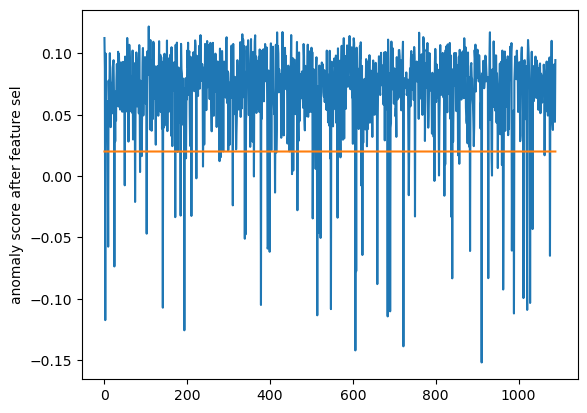

Shape of the training set: (1013, 147)


In [12]:
outlierdet = IsolationForest(random_state=0, contamination=0.05, max_features=0.5).fit(X_train_sc_imp)
anomaly_score2 = outlierdet.decision_function(X_train_sc_imp)

anomaly_threshold2 = 0.02
plt.plot(anomaly_score2)
plt.plot(np.ones(anomaly_score2.shape)*anomaly_threshold2)
plt.ylabel('anomaly score after feature sel')
plt.show()

outliers=np.where(anomaly_score2 < anomaly_threshold2)

mask = np.ones(len(anomaly_score2), dtype=bool)
mask[outliers[0]] = False
X_train_cl = X_train_sc_imp[mask,:]
y_train_cl = y_train_sel[mask]

print('Shape of the training set:', X_train_cl.shape)

### regression models

In [9]:
############# Regression using a decision tree #############

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
reg_model = DecisionTreeRegressor(random_state=0, min_samples_split=0.01)
n_scores = cross_val_score(reg_model, X_train_cl, y_train_cl, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 0.159 (0.194)


In [10]:

run_list = [0,1,1,0,1]

############# Regression using a random forest #############
if run_list[0]:
    rf_reg = ExtraTreesRegressor(n_estimators=100, random_state=0, min_samples_split=5, max_samples=None)
    n_scores_0 = cross_val_score(rf_reg, X_train_cl, y_train_cl, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('ExtraTrees: %.3f (%.3f)' % (np.mean(n_scores_0), np.std(n_scores_0)))
    regressor = rf_reg.fit(X_train_cl, y_train_cl)
    y_predicted_rf = regressor.predict(X_test_sc_imp)



############# Regression using HistGradientBoostingRegressor #############
if run_list[1]:
    HGB_reg = HistGradientBoostingRegressor(max_iter=200, learning_rate = 0.1, l2_regularization = 10)
    n_scores_1 = cross_val_score(HGB_reg, X_train_cl, y_train_cl, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('HBG: %.3f (%.3f)' % (np.mean(n_scores_1), np.std(n_scores_1)))
    regressor = HGB_reg.fit(X_train_cl, y_train_cl)
    y_predicted_hgb = regressor.predict(X_test_sc_imp)

############# Regression using SVR #############
if run_list[2]:
    SVR_reg = SVR(kernel='rbf', degree=50, gamma=0.011, coef0=0.0, tol=0.1, C=100, epsilon=0.1, shrinking=True, cache_size=200)
    n_scores_2 = cross_val_score(SVR_reg, X_train_cl, y_train_cl, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('SVR: %.3f (%.3f)' % (np.mean(n_scores_2), np.std(n_scores_2)))
    regressor = SVR_reg.fit(X_train_cl, y_train_cl)
    y_predicted_svr = regressor.predict(X_test_sc_imp)
    
############# Regression using adaboost #############
if run_list[3]:
    ada_regr = AdaBoostRegressor(random_state=0, n_estimators=1000, loss='square', learning_rate=0.5)
    n_scores_3 = cross_val_score(ada_regr, X_train_cl, y_train_cl, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('Ada: %.3f (%.3f)' % (np.mean(n_scores_3), np.std(n_scores_3)))

############# Regression using MLP #############
if run_list[4]:
    MLP_reg = MLPRegressor(random_state=10, max_iter=10000,activation='tanh',solver='sgd',alpha=10, hidden_layer_sizes=(200))
    n_scores_4 = cross_val_score(MLP_reg, X_train_cl, y_train_cl, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('MLP: %.3f (%.3f)' % (np.mean(n_scores_4), np.std(n_scores_4)))
    regressor = MLP_reg.fit(X_train_cl, y_train_cl)
    y_predicted_mlp = regressor.predict(X_test_sc_imp)


HBG: 0.604 (0.060)
SVR: 0.622 (0.051)
MLP: 0.594 (0.070)


In [11]:
############# Write out the predictions to a csv file #############
y_predicted = 1/3*(y_predicted_svr + y_predicted_mlp + y_predicted_hgb)
d = {'id': range(len(y_predicted)), 'y': y_predicted}
y_predicted_df = pd.DataFrame(data=d)
y_predicted_df.to_csv("baseline_triple_average.csv", index=False)